# Look at  the Data

In [28]:
# Import necesaary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Ensure reproducability
np.random.seed(0)

In [29]:
# Load the .mat file
data_train = loadmat("Data/Training_EEG.mat")
data_test = loadmat("Data/Test_EEG.mat")

# Look at training data
print("Training Data Contents:\n")
for  key, item in data_train.items():
    if type(item) != np.ndarray:
        print(f"{key}: {item}")
    else:
        print(f"{key}: shape {np.shape(item)}")
        print(f" Complex: {item.dtype.kind == 'c'}")
print("\n")

# Look at test data
print("Test Data Contents:\n")
for  key, item in data_test.items():
    if type(item) != np.ndarray:
        print(f"{key}: {item}")
    else:
        print(f"{key}: shape {np.shape(item)}")
        print(f" Complex: {item.dtype.kind == 'c'}")
print("\n")


# Extract variables
train_blinks = data_train['blinks'] - 1 # Binary vector indicating indexes of blink events in training data (1, 2896)
train_EEG = data_train['train_eeg'] # EEG training data (19, 9600)
test_EEG = data_test['test_eeg'] # EEG test data (19, 96801)
N = np.shape(train_EEG)[0] # Number of electrodes
len_train_eeg = np.shape(train_EEG)[1] # Length of training EEG signals

Training Data Contents:

__header__: b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Oct  6 16:25:11 2022'
__version__: 1.0
__globals__: []
blinks: shape (1, 2896)
 Complex: False
train_eeg: shape (19, 9600)
 Complex: False


Test Data Contents:

__header__: b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Oct  6 16:25:54 2022'
__version__: 1.0
__globals__: []
test_eeg: shape (19, 96801)
 Complex: False




## Visualize the data

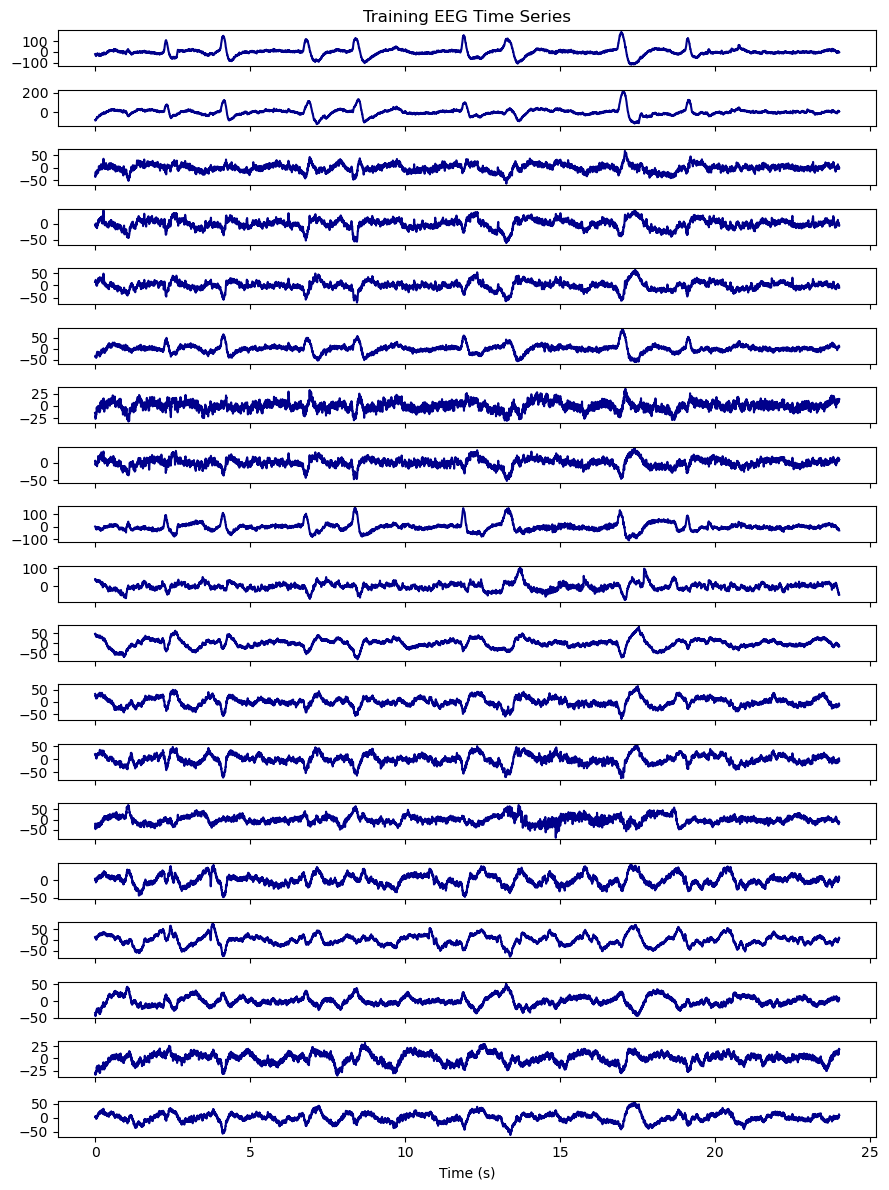

In [30]:
# Look at the training EEG time series
Fs = 400
t = np.linspace(0, len_train_eeg/Fs, len_train_eeg)

fig, axs = plt.subplots(19, 1, figsize=(9, 12), sharex=True)

for i in range(19):
    axs[i].plot(t, train_EEG[i], color='darkblue')
    if i == 0:
        axs[i].set_title('Training EEG Time Series')
    if i == 18:
        axs[i].set_xlabel('Time (s)')

plt.tight_layout()


Text(0.5, 0, 'Time (s)')

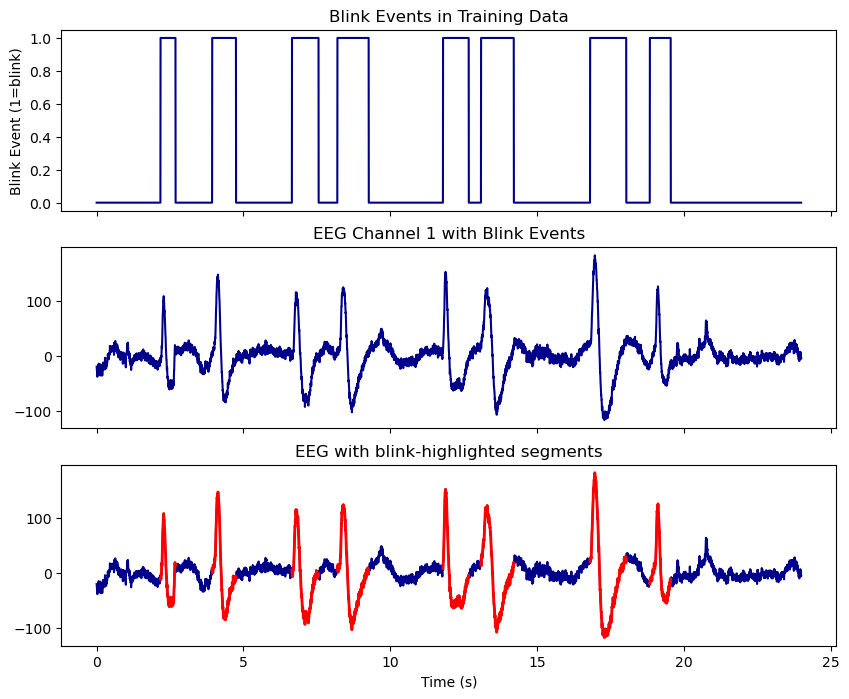

In [31]:
# Plot blink events
blinks = np.zeros(len_train_eeg, dtype=int)
blinks[train_blinks] = 1
highlight = np.where(blinks == 1, train_EEG[0], np.nan)

fig, axs = plt.subplots(3, 1, figsize = (10,8), sharex=True)
axs[0].plot(t, blinks, color='darkblue')
axs[0].set_title('Blink Events in Training Data')
axs[0].set_ylabel('Blink Event (1=blink)')

axs[1].plot(t, train_EEG[0], color='darkblue')
axs[1].set_title('EEG Channel 1 with Blink Events')

axs[2].plot(t, train_EEG[0], color='darkblue')
axs[2].plot(t, highlight, color='red', linewidth=2)
axs[2].set_title("EEG with blink-highlighted segments")
axs[2].set_xlabel('Time (s)')

In [32]:
# Further look at the blinks
blink_starts = []
blink_ends = []
previous_state = blinks[0]
for i in range(1, len_train_eeg):
    current_state = blinks[i]
    rising_edge = current_state - previous_state
    if rising_edge == 1:
        blink_starts.append(i)
    elif rising_edge == -1:
        blink_ends.append(i)
    previous_state = current_state
print(f"Blink event beginnings (in samples): {blink_starts}")

# Look at blink event intervals
blink_starts = np.array(blink_starts)
blink_ends = np.array(blink_ends)
blink_durations = blink_ends - blink_starts
# print all blink event durations
print(f"Blink event durations (in samples): {blink_durations}")
print(f"Average blink duration: {np.mean(blink_durations):.3f} samples")

Blink event beginnings (in samples): [870, 1574, 2661, 3280, 4719, 5237, 6723, 7537]
Blink event durations (in samples): [205 325 363 427 351 447 493 285]
Average blink duration: 362.000 samples


SNR Channel 1: 13.62 dB
SNR Channel 2: 11.11 dB
SNR Channel 3: 2.80 dB
SNR Channel 4: 4.88 dB
SNR Channel 5: 6.77 dB
SNR Channel 6: 9.56 dB
SNR Channel 7: 1.96 dB
SNR Channel 8: 5.78 dB
SNR Channel 9: 10.28 dB
SNR Channel 10: 4.46 dB
SNR Channel 11: 4.35 dB
SNR Channel 12: 5.00 dB
SNR Channel 13: 6.42 dB
SNR Channel 14: 1.90 dB
SNR Channel 15: 2.17 dB
SNR Channel 16: 2.29 dB
SNR Channel 17: 3.42 dB
SNR Channel 18: 1.56 dB
SNR Channel 19: 4.93 dB


Text(0, 0.5, 'SNR (dB)')

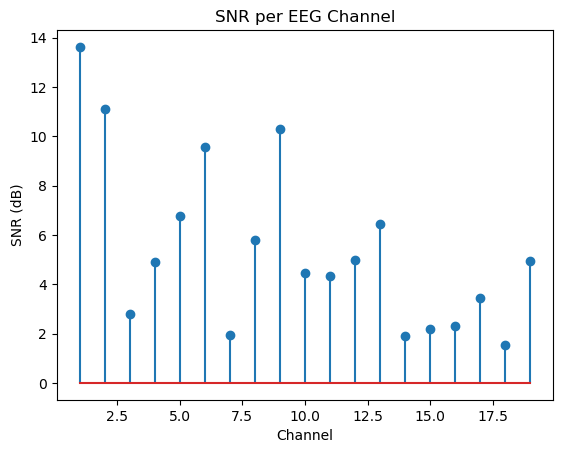

In [33]:
# Look at SNR per channel
SNR_channels = []
for i in range(N):
    signal_power = np.mean(train_EEG[i][blinks == 1]**2)
    noise_power = np.mean(train_EEG[i][blinks == 0]**2)
    SNR = 10 * np.log10(signal_power / noise_power)
    print(f"SNR Channel {i+1}: {SNR:.2f} dB")
    SNR_channels.append(SNR)

# Plot SNR per channel
plt.stem(range(1, N+1), SNR_channels)
plt.title('SNR per EEG Channel')
plt.xlabel('Channel')
plt.ylabel('SNR (dB)')

# Processing data for the Detector and Estimator

In [34]:
# Create function to frame data
def frame_data(data, N_f, Overlap, channels):
    len_data = np.shape(data)[1]
    Hop = int(N_f*(1-Overlap))
    K_f = int((len_data-N_f)/Hop) + 1 # Number of frames per signal

    # Creating a data array with overlapping frames of high SNR channels
    Y = []
    for m in channels:
        Y_m = []
        for k in range(K_f):
            y = data[m][k*Hop: k*Hop+N_f]
            Y_m.append(y)
        Y.append(Y_m)
    Y = np.array(Y) # Shape (M, K_f, N_f)
    print(f"Number of frames per signal: {K_f}")
    print(f"Frame length: {N_f}")
    print(f"Shape of framed data array Y: {Y.shape}")
    return Y, K_f

# Creating array
Y, K_f = frame_data(train_EEG, N_f=300, Overlap=0.75, channels=[0, 1, 5, 8])

Number of frames per signal: 125
Frame length: 300
Shape of framed data array Y: (4, 125, 300)


## Making the Detector

In [35]:
# First find all frames that contain blink artifacts
N_f = 300
Overlap = 0.75
Hop = int(N_f*(1-Overlap))
starts = np.arange(K_f) * Hop
ends = starts + N_f - 1

tau = 0.30  # 30% overlap threshold

is_blink_frame = np.zeros(K_f, dtype=bool)
overlap_frac = np.zeros(K_f, dtype=float)
for k in range(K_f):
    s, e = starts[k], ends[k]

    # total number of blink samples inside this frame
    overlap = 0
    for bs, be in zip(blink_starts, blink_ends):
        overlap += max(0, min(e, be) - max(s, bs) + 1)

    overlap_frac[k] = overlap / N_f
    is_blink_frame[k] = overlap_frac[k] >= tau

# Add a guard interval
guard = 1
is_blink_guarded = is_blink_frame.copy()
blink_idx = np.where(is_blink_frame)[0]
for k in blink_idx:
    is_blink_guarded[max(0, k-guard):min(K_f, k+guard+1)] = True

print("Blink frames:", is_blink_frame.sum(), "/", K_f)
print("Blink frames with guard interval:", is_blink_guarded.sum(), "/", K_f)

# Look at first blink frame and see if correct frames get marked
print(f'First blink start: {blink_starts[0]}')
print(f'First blink end: {blink_ends[0]}')

first_blink_frames = np.argwhere(is_blink_guarded==True).flatten()
print(f'First few blink frames {first_blink_frames[0:6]}')
print(f'First few frames beginnings {starts[first_blink_frames[0:6]]}')

first_blink_frames_wg = np.argwhere(is_blink_frame==True).flatten()
print(f'First few blink frames {first_blink_frames_wg[0:6]}')
print(f'First few frames beginnings {starts[first_blink_frames_wg[0:6]]}')

Blink frames: 55 / 125
Blink frames with guard interval: 68 / 125
First blink start: 870
First blink end: 1075
First few blink frames [ 8  9 10 11 12 13]
First few frames beginnings [600 675 750 825 900 975]
First few blink frames [ 9 10 11 12 13 19]
First few frames beginnings [ 675  750  825  900  975 1425]


### Creating the threshold via the NP method

In [36]:
# statistic
Yd = Y[0] - Y[0].mean(axis=1, keepdims=True)
T  = np.sum(Yd**2, axis=1)/N_f             # (K_f,)

# H0 samples
T0 = T[~is_blink_guarded]

# Threshold
PFA = 0.01
gamma = np.quantile(T0, 1 - PFA)
print(f'Threshold gamma: {gamma:.2f}')

Threshold gamma: 344.60


In [37]:
# Look at how well the detection worked
det = T > gamma

# Print detected blink frames
print(f"Detection results:{starts[det][:10]}")
print(f"True blink frames: {starts[is_blink_frame][:10]}")

gt = is_blink_frame          
pred = det
TP = np.sum(pred & gt)
FP = np.sum(pred & ~gt)
FN = np.sum(~pred & gt)
TN = np.sum(~pred & ~gt)

PFA_emp = FP / (FP + TN + 1e-12)
PD_emp  = TP / (TP + FN + 1e-12)

print("Empirical PFA:", PFA_emp)
print("Empirical PD:", PD_emp)


Detection results:[ 675  750  825  900  975 1350 1425 1500 1575 1650]
True blink frames: [ 675  750  825  900  975 1425 1500 1575 1650 1725]
Empirical PFA: 0.04285714285714225
Empirical PD: 0.9454545454545282


# Creating the Estimator

In [38]:
# Create Hankel matrix
def create_hankel_matrices(Y, L):
    M, K_f, N_f = Y.shape
    Yd = Y - Y.mean(axis=2, keepdims=True)  
    Y_hankel = []
    for k in range(K_f):
        Y_hankel_k = []
        for m in range(M):
            y = Yd[m, k]
            # Create Hankel matrix for frame y
            K = N_f - L + 1  # Number of columns
            hankel_matrix = np.zeros((L, K))
            for i in range(L):
                hankel_matrix[i, :] = y[i:i+K]
            Y_hankel_k.append(hankel_matrix)
        Y_hankel_k = np.array(Y_hankel_k)  # Shape (M, L, K)
        Y_hankel_k_stacked = Y_hankel_k.reshape(M*L, -1)  # Shape (M*L, K)
        Y_hankel.append(Y_hankel_k_stacked)
    return np.array(Y_hankel) # Shape (K_f, M*L, K)


Henkel = create_hankel_matrices(Y, L=15)
print(f"Shape of Hankel matrices array H: {Henkel.shape}")  # Should be (K_f, M*L, K)

Shape of Hankel matrices array H: (125, 60, 286)


In [43]:
# Create autocorrelation matrices
def compute_autocorr_matrices(Henkel):
    K_f, ML, K = Henkel.shape
    R = []
    for k in range(K_f):
        H_k = Henkel[k]
        Hc = H_k - H_k.mean(axis=1, keepdims=True)
        R_k = (Hc @ Hc.T) / K  # Autocorrelation matrix
        R.append(R_k)
    return np.array(R)  # Shape (K_f, M*L, M*L)


# Use autocorrelation matrices to compute test statistic
def detector(Y, gamma, guard=1):
    N_f = Y.shape[2]
    K_f = Y.shape[1]
    Yd = Y[0] - Y[0].mean(axis=1, keepdims=True)
    T  = np.sum(Yd**2, axis=1)/N_f
    detected_blinks = T > gamma
    det_guard = detected_blinks.copy()
    for k in np.where(detected_blinks)[0]:
        det_guard[max(0,k-guard):min(K_f,k+guard+1)] = True
    return det_guard


# Create function to average over anti-diagonals
def avg_anti_diag(X_m):  # X_m: (L, K)
    L, K = X_m.shape
    Nf = L + K - 1
    x = np.zeros(Nf)
    c = np.zeros(Nf)
    for i in range(L):
        for j in range(K):
            x[i+j] += X_m[i,j]
            c[i+j] += 1
    return x / np.maximum(c, 1)


# Create window and add function
def overlap_add(X_estimates, overlap):
    K_f, M, N_f = X_estimates.shape
    Hop = int(N_f * (1 - overlap))
    len_data = Hop * (K_f - 1) + N_f

    X_reconstructed = np.zeros((M, len_data))
    Wsum = np.zeros(len_data)
    W = np.bartlett(N_f)

    for k in range(K_f):
        start = k * Hop
        end = start + N_f
        Wsum[start:end] += W
        X_reconstructed[:, start:end] += X_estimates[k] * W

    # normalize (avoid divide by zero)
    X_reconstructed /= np.maximum(Wsum, 1e-12)
    return X_reconstructed



# Create full estimator pipeline
def estimate_blinks(data, N_f, Overlap, L, channels, gamma):
    # Get parameters
    M = len(channels)

    # Frame data
    Y, K_f = frame_data(data, N_f, Overlap, channels) #(M, K_f, N_f)

    # First create Hankel matrices
    Hankel = create_hankel_matrices(Y, L)    #(K_f, M*L, K)

    # Then compute autocorrelation matrices
    R = compute_autocorr_matrices(Hankel)    #(K_f, M*L, M*L)

    # Detect blinks
    detected_blinks = detector(Y, gamma)     #(K_f,)

    # Use detected blinks to estimate blink
    X_estimates = []
    lam = 0.98 
    Ryy = None
    Rvv = None
    for k in range(K_f):
        Rk = R[k]

        # initialize
        if Ryy is None:
            Ryy = Rk.copy()
        else:
            Ryy = lam * Ryy + (1 - lam) * Rk

        if Rvv is None:
            # initialize Rvv using the first clean frame you encounter
            if not detected_blinks[k]:
                Rvv = Rk.copy()
            else:
                # if first frames are blink, just keep Rvv equal to Ryy initially
                Rvv = Ryy.copy()
        else:
            if not detected_blinks[k]:
                Rvv = lam * Rvv + (1 - lam) * Rk
            # else: keep Rvv unchanged

        Hx = np.eye(M*L) - Rvv @ np.linalg.pinv(Ryy)
        x_k_est = Hx @ Hankel[k]   # (M*L, K)

        
        # Average over antidiagonals to reconstruct signal
        x_avg_est = np.zeros((M, N_f))
        for i in range(M):
            X_m = x_k_est[i*L:(i+1)*L, :]  # X_m: (L, K)
            x_m_est = avg_anti_diag(X_m)    # x_m_est: (N_f,)
            x_avg_est[i, :] = x_m_est
        X_estimates.append(x_avg_est)

    # Window frames and add them together
    X_estimates = np.array(X_estimates)  # (K_f, M, N_f)
    X_estimates = overlap_add(X_estimates, Overlap)  # (M, len_data)

    return X_estimates

### Test Estimation

Number of frames per signal: 125
Frame length: 300
Shape of framed data array Y: (4, 125, 300)


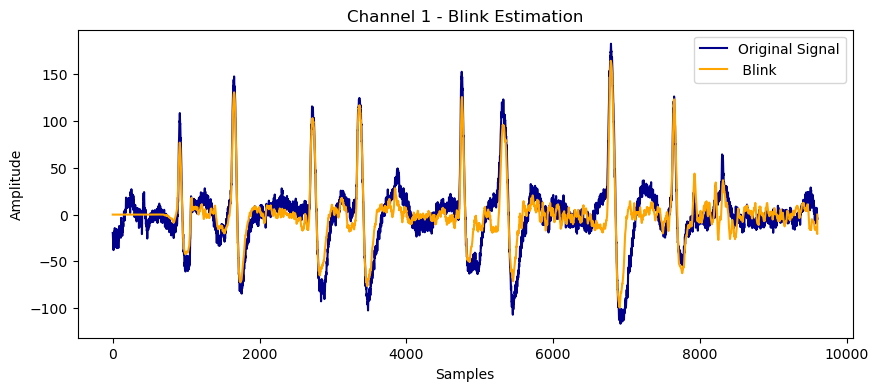

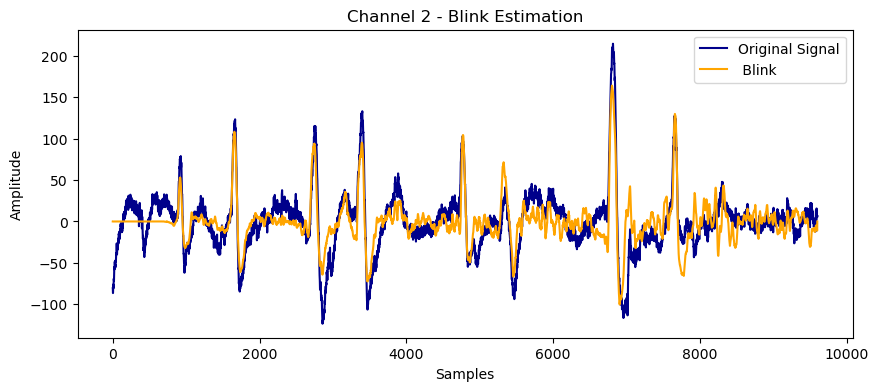

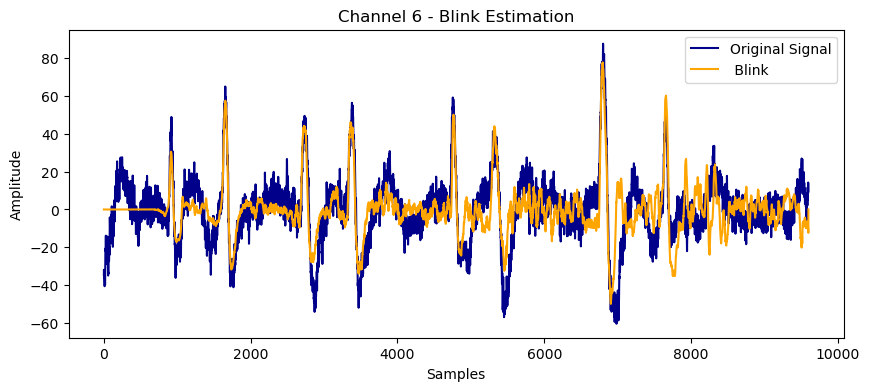

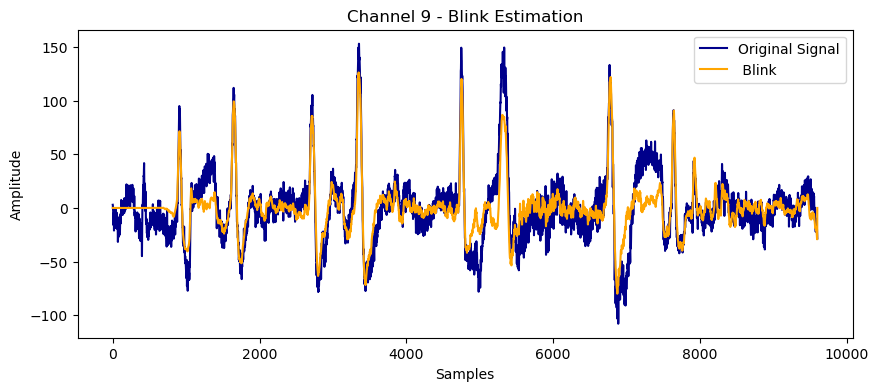

In [44]:
# Parameters
N_f = 300
Overlap = 0.75
L = 15
channels = [0, 1, 5, 8]
gamma = gamma

X = estimate_blinks(data=train_EEG, N_f=N_f, Overlap=Overlap, L=L, channels=channels, gamma=gamma)

# Plot results
for i, ch in enumerate(channels):
    plt.figure(figsize=(10,4))
    plt.plot(train_EEG[ch], label='Original Signal', color='darkblue')
    plt.plot(X[i], label=' Blink', color='orange')
    plt.title(f'Channel {ch+1} - Blink Estimation')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


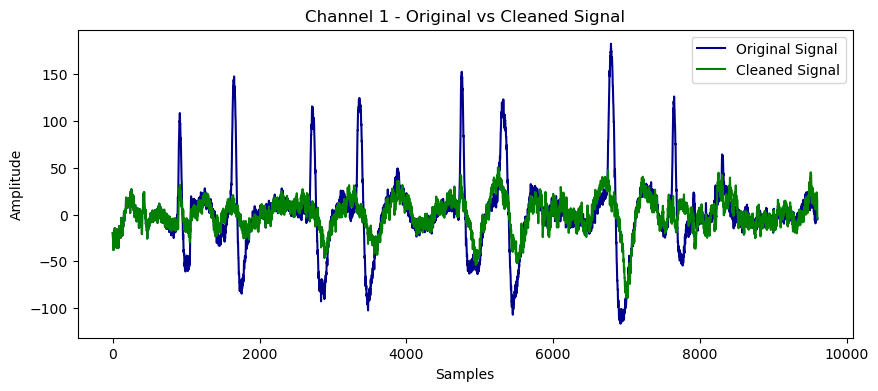

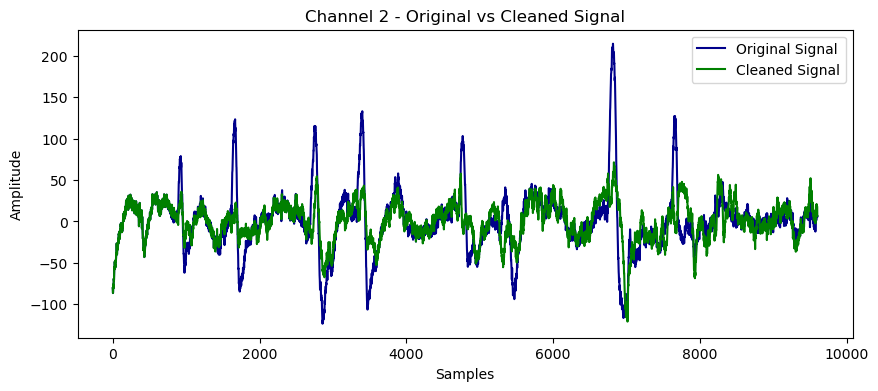

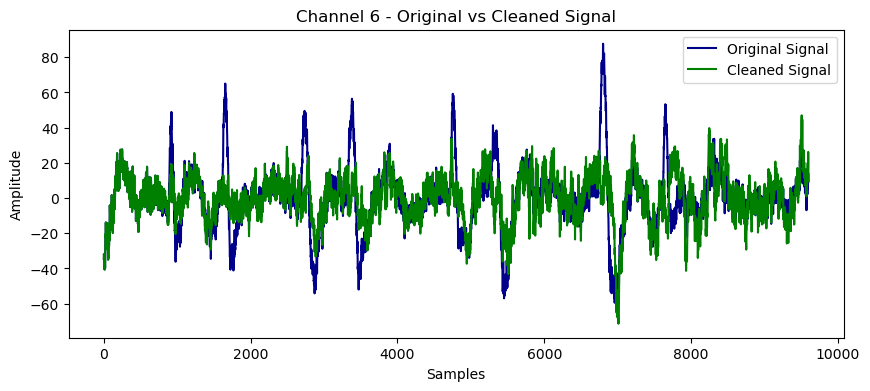

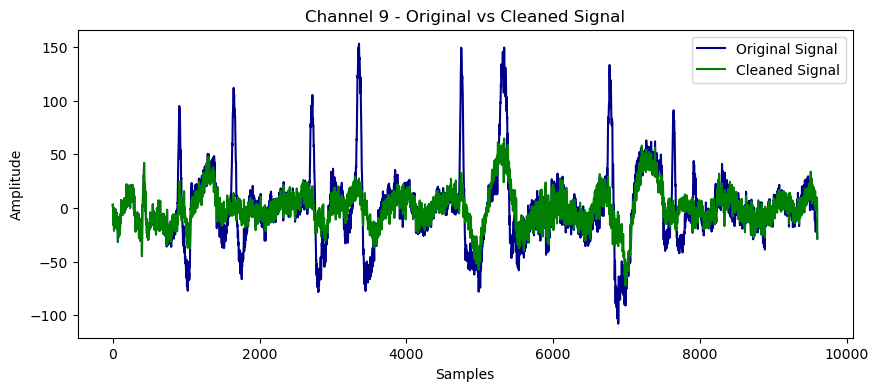

In [45]:
# Plot original vs cleaned signal for a channel
for i, ch in enumerate(channels):
    cleaned_signal = train_EEG[ch] - X[i]
    plt.figure(figsize=(10,4))
    plt.plot(train_EEG[ch], label='Original Signal', color='darkblue')
    plt.plot(cleaned_signal, label='Cleaned Signal', color='green')
    plt.title(f'Channel {ch+1} - Original vs Cleaned Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Now estimate on the test data

Number of frames per signal: 1287
Frame length: 300
Shape of framed data array Y: (4, 1287, 300)


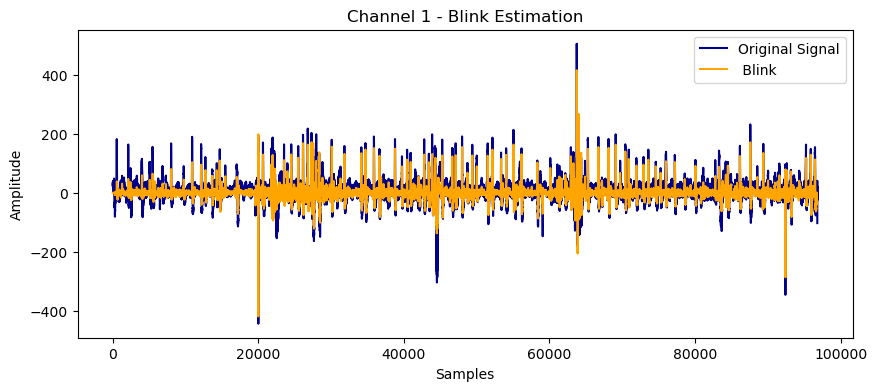

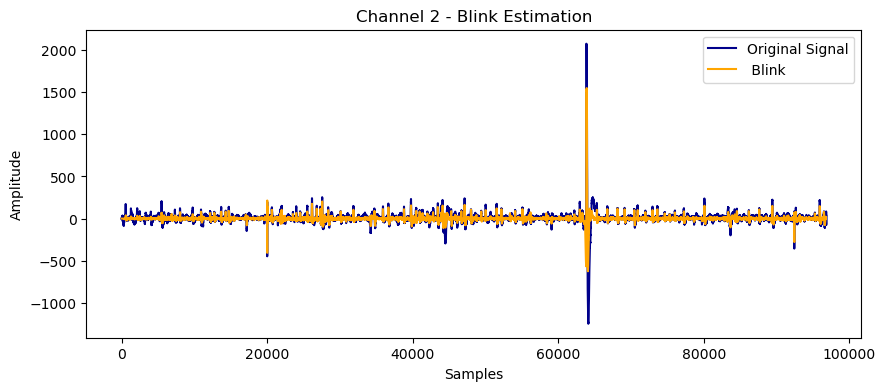

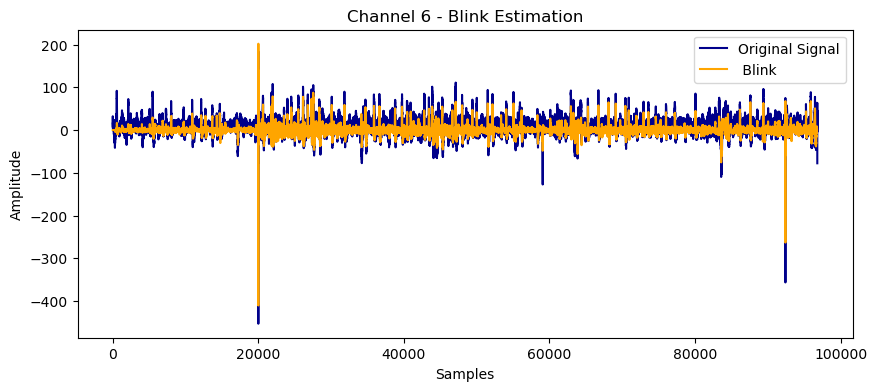

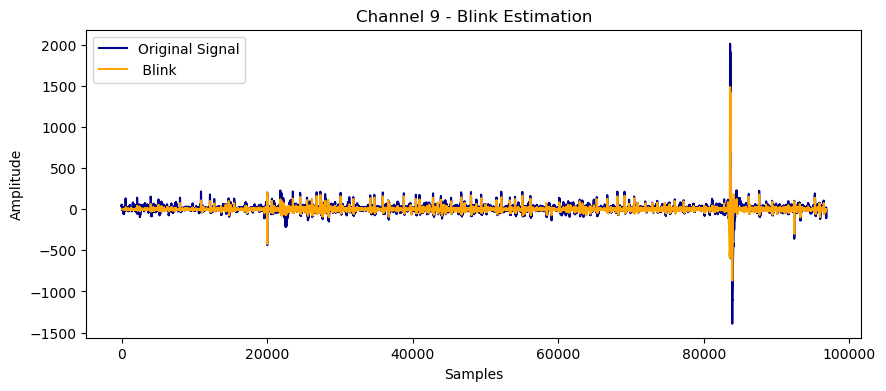

In [46]:
# Parameters
N_f = 300
Overlap = 0.75
L = 15
channels = [0, 1, 5, 8]
gamma = gamma

X_test = estimate_blinks(data=test_EEG, N_f=N_f, Overlap=Overlap, L=L, channels=channels, gamma=gamma)

# Plot results
for i, ch in enumerate(channels):
    plt.figure(figsize=(10,4))
    plt.plot(test_EEG[ch], label='Original Signal', color='darkblue')
    plt.plot(X_test[i], label=' Blink', color='orange')
    plt.title(f'Channel {ch+1} - Blink Estimation')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


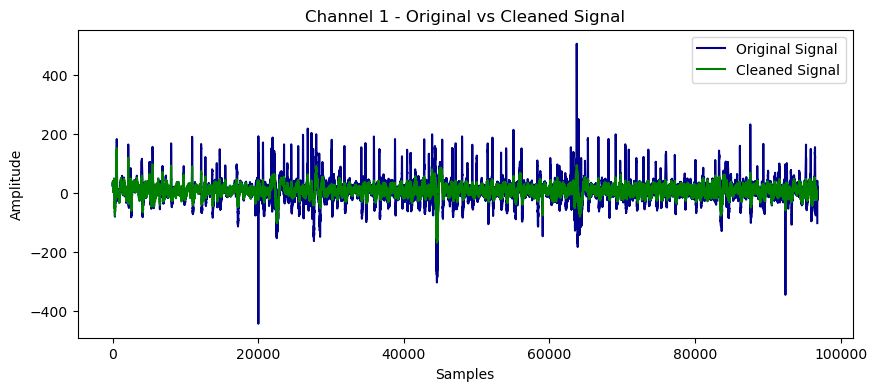

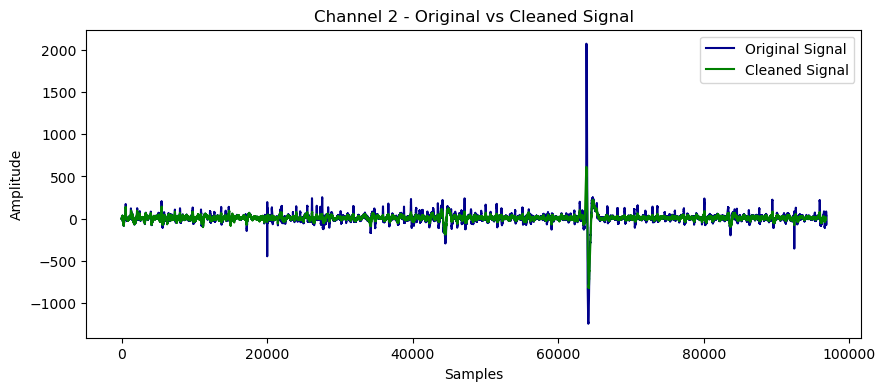

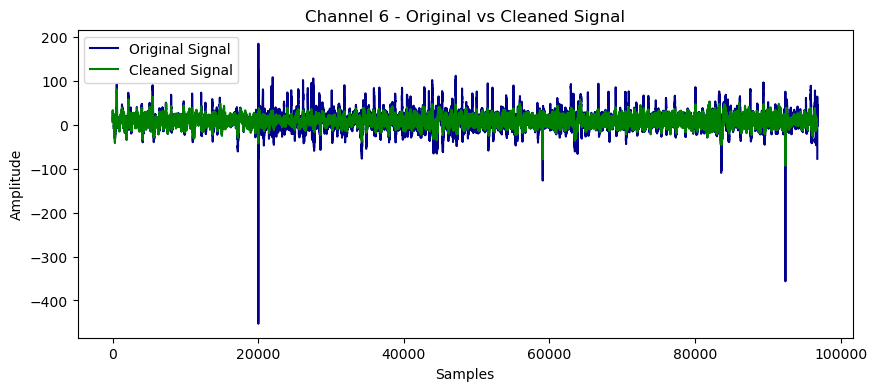

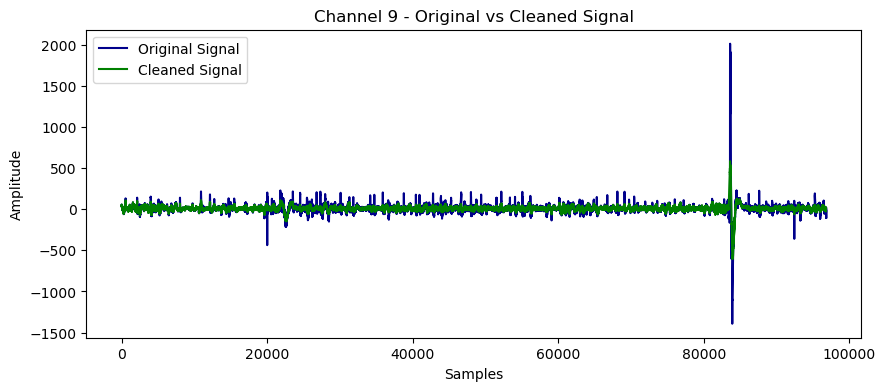

In [52]:
# Plot original vs cleaned signal for a channel
for i, ch in enumerate(channels):
    cleaned_signal_test = test_EEG[ch][:96750] - X_test[i]
    plt.figure(figsize=(10,4))
    plt.plot(test_EEG[ch], label='Original Signal', color='darkblue')
    plt.plot(cleaned_signal_test, label='Cleaned Signal', color='green')
    plt.title(f'Channel {ch+1} - Original vs Cleaned Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()